# 3.0 Build predictive model

In [171]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
from sklearn.preprocessing import Imputer
from sklearn.base import TransformerMixin
from sklearn import cross_validation
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import os

%matplotlib inline

path = '/'.join(os.getcwd().split('/')[:-1])
print path

/Volumes/Dropbox/largetransfer/luc/carter


In [172]:
def sound():
    os.system('afplay /System/Library/Sounds/Sosumi.aiff')

In [217]:
df = pd.read_csv(path+'/data/model_data/tci_2_3.csv')
df.shape

(122560, 85)

In [174]:
df.columns

Index([u'Parcel ID', u'ppn', u'vacant', u'Date', u'Survey Category',
       u'Survey Result', u'zip', u'pclass', u'totusabl', u'tmktval',
       u'condition', u'parcel_x', u'condition_value', u'parcel_y',
       u'style_filtered', u'parcel_x.1', u'ownerocc_value', u'parcel_y.1',
       u'totbldgs', u'parcel_x.2', u'yrbuilt_filtered', u'parcel_y.2',
       u'rextwall', u'parcel_x.1', u'vacant_block', u'owner', u'renter',
       u'median_rent', u'property_crimes', u'burglaries', u'other_drug',
       u'part_one_crimes', u'part_two_crimes', u'bachelors+', u'poverty_rate',
       u'median_hh_income', u'median_fam_income', u'white', u'black', u'asian',
       u'other', u'hispanic', u'young', u'middle', u'old', u'num_of_sales',
       u'quit_claim_deed', u'warranty_deed', u'limited_warranty',
       u'survivorship_deed', u'fiduciary_deed', u'AMOUNT_PAID', u'SALE_VALID',
       u'num_of_transfers', u'DEED_TYPE', u'county_land_bank', u'vindall_Y',
       u'vindall_P', u'violations_number', u'v

#### Change 'pclass' into residential/non-residential

Only use data from residential parcels in the model.


In [175]:
df = df[df.pclass=='Residential']
df.shape

(122560, 85)

#### Count missing values as a variable

In [176]:
df['missing_values'] = df.apply(lambda x: len(x[x.isnull()]),axis=1)

#### Let's look at total market value, property size, etc.

In [179]:
def is_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

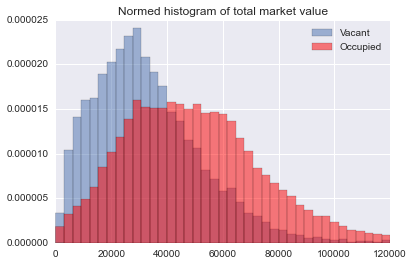

In [180]:
b = np.linspace(0, 120000, 40)
plt.hist(df.loc[(~is_outlier(df.tmktval)) & (df.vacant==1),'tmktval'].values,bins=b,alpha=0.5,normed=True,label='Vacant');
plt.hist(df.loc[(~is_outlier(df.tmktval)) & (df.vacant==0),'tmktval'].values,bins=b,color='r',alpha=0.5,normed=True,label='Occupied');
plt.legend();
plt.title('Normed histogram of total market value');

In [161]:
# b = np.linspace(0, 10000, 40)
# plt.hist(df.loc[(~is_outlier(df.propsize)) & (df.vacant==1),'propsize'].values,bins=b,alpha=0.5,normed=True,label='Vacant');
# plt.hist(df.loc[(~is_outlier(df.propsize)) & (df.vacant==0),'propsize'].values,bins=b,color='r',alpha=0.5,normed=True,label='Occupied');
# plt.legend();
# plt.title('Normed histogram of property size');

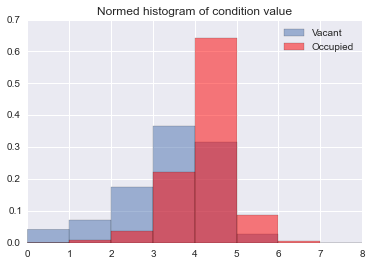

In [162]:
b = np.linspace(0, 8, 9)
plt.hist(df.loc[((df.condition_value.notnull())) & (df.vacant==1),'condition_value'].values,bins=b,alpha=0.5,normed=True,label='Vacant');
plt.hist(df.loc[((df.condition_value.notnull())) & (df.vacant==0),'condition_value'].values,bins=b,color='r',alpha=0.5,normed=True,label='Occupied');
plt.legend();
plt.title('Normed histogram of condition value');

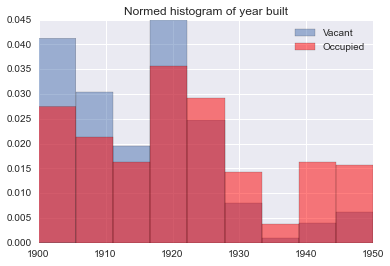

In [163]:
b = np.linspace(1900, 1950, 10)
plt.hist(df.loc[(~is_outlier(df.yrbuilt_filtered)) & (df.vacant==1),'yrbuilt_filtered'].values,bins=b,alpha=0.5,normed=True,label='Vacant');
plt.hist(df.loc[(~is_outlier(df.yrbuilt_filtered)) & (df.vacant==0),'yrbuilt_filtered'].values,bins=b,color='r',alpha=0.5,normed=True,label='Occupied');
plt.legend();
plt.title('Normed histogram of year built');

In [184]:
to_remove = ['Parcel ID','ppn','Date','Survey Category','Survey Result','pclass','parcel_x','parcel_y','parcel_x.1', \
             'parcel_x.1','parcel_y.1','parcel_y.1','parcel_x.2','parcel_y.2','PROPERTY_NUMBER','condition','missing_values', \
             'zip']

In [185]:
df.columns.values

array(['Parcel ID', 'ppn', 'vacant', 'Date', 'Survey Category',
       'Survey Result', 'zip', 'pclass', 'totusabl', 'tmktval',
       'condition', 'parcel_x', 'condition_value', 'parcel_y',
       'style_filtered', 'parcel_x.1', 'ownerocc_value', 'parcel_y.1',
       'totbldgs', 'parcel_x.2', 'yrbuilt_filtered', 'parcel_y.2',
       'rextwall', 'parcel_x.1', 'vacant_block', 'owner', 'renter',
       'median_rent', 'property_crimes', 'burglaries', 'other_drug',
       'part_one_crimes', 'part_two_crimes', 'bachelors+', 'poverty_rate',
       'median_hh_income', 'median_fam_income', 'white', 'black', 'asian',
       'other', 'hispanic', 'young', 'middle', 'old', 'num_of_sales',
       'quit_claim_deed', 'warranty_deed', 'limited_warranty',
       'survivorship_deed', 'fiduciary_deed', 'AMOUNT_PAID', 'SALE_VALID',
       'num_of_transfers', 'DEED_TYPE', 'county_land_bank', 'vindall_Y',
       'vindall_P', 'violations_number', 'violations_number_1_yr',
       'c_Black Mold', 'c_Collapsing

In [186]:
features = list(df.columns.values)
for i in to_remove:
    print i
    features.remove(i)

Parcel ID
ppn
Date
Survey Category
Survey Result
pclass
parcel_x
parcel_y
parcel_x.1
parcel_x.1
parcel_y.1
parcel_y.1
parcel_x.2
parcel_y.2
PROPERTY_NUMBER
condition
missing_values
zip


In [187]:
for i,j in enumerate(features):
    print i,j

0 vacant
1 totusabl
2 tmktval
3 condition_value
4 style_filtered
5 ownerocc_value
6 totbldgs
7 yrbuilt_filtered
8 rextwall
9 vacant_block
10 owner
11 renter
12 median_rent
13 property_crimes
14 burglaries
15 other_drug
16 part_one_crimes
17 part_two_crimes
18 bachelors+
19 poverty_rate
20 median_hh_income
21 median_fam_income
22 white
23 black
24 asian
25 other
26 hispanic
27 young
28 middle
29 old
30 num_of_sales
31 quit_claim_deed
32 warranty_deed
33 limited_warranty
34 survivorship_deed
35 fiduciary_deed
36 AMOUNT_PAID
37 SALE_VALID
38 num_of_transfers
39 DEED_TYPE
40 county_land_bank
41 vindall_Y
42 vindall_P
43 violations_number
44 violations_number_1_yr
45 c_Black Mold
46 c_Collapsing Structure
47 c_Complete interior/exterior
48 c_Debris/Garbage/Junk (Occupied)
49 c_Electrical
50 c_Fire Damage
51 c_General Exterior Maintenance
52 c_No Permit
53 c_O.V.V.
54 c_Plumbing
55 complaint_count
56 complaint_count_6_mon
57 complaint_count_3_mon
58 active_fc
59 foreclosure_flag
60 fc_dis_w/

In [188]:
# 'propsize','totusabl','tmktval',

# cols = ['propsize','tmktval','condition_value','totbldgs','yrbuilt_filtered','vacant', \
#         'num_of_sales','quit_claim_deed','warranty_deed',
#         'violations_number', 'missing_values', 'ownerocc_value',\
#         'vindall_Y', 'complaint_count','complaint_count_6_mon', 'complaint_count_3_mon']

### Impute with median values

In [189]:
for i in features[9:30]:
    df.loc[df[i].isnull(),i] = np.median(df.loc[df[i].notnull(),i])

In [190]:
# df.loc[df.propsize.isnull(),'propsize'] = np.median(df[df.propsize.notnull()].propsize)
df.loc[df.totusabl.isnull(),'totusabl'] = np.median(df[df.totusabl.notnull()].totusabl)
df.loc[df.tmktval.isnull(),'tmktval'] = np.median(df[df.tmktval.notnull()].tmktval)
df.loc[df.condition_value.isnull(),'condition_value'] = np.median(df[df.condition_value.notnull()].condition_value)
df.loc[df.totbldgs.isnull(),'totbldgs'] = np.median(df[df.totbldgs.notnull()].totbldgs)
df.loc[df.yrbuilt_filtered.isnull(),'yrbuilt_filtered'] = np.median(df[df.yrbuilt_filtered.notnull()].yrbuilt_filtered)
df.loc[df.ownerocc_value.isnull(),'ownerocc_value'] = np.median(df[df.ownerocc_value.notnull()].ownerocc_value)

In [191]:
print df.columns[df.dtypes == 'object']

Index([u'Parcel ID', u'ppn', u'Date', u'Survey Category', u'Survey Result',
       u'pclass', u'condition', u'parcel_x', u'parcel_y', u'style_filtered',
       u'parcel_x.1', u'parcel_y.1', u'parcel_x.2', u'parcel_y.2', u'rextwall',
       u'parcel_x.1', u'DEED_TYPE', u'parcel_y.1', u'PROPERTY_NUMBER',
       u'LENDER_PROCESS_TYPE'],
      dtype='object')


In [192]:
objs = ['DEED_TYPE','LENDER_PROCESS_TYPE','rextwall','style_filtered']
prefixes = ['deed_','lender_','ext_','style_']

In [193]:
df.loc[df.rextwall.notnull(),['rextwall','vacant']].groupby('rextwall').agg([sum,len])

vacant       
                        sum    len
rextwall                          
Aluminum/Vinyl (r)     3873  71201
Asbestos Shingle (r)    209   2313
Brick                   400  10628
Frame (r)              2576  26891
Other                 -8708  11527

In [194]:
objs

['DEED_TYPE', 'LENDER_PROCESS_TYPE', 'rextwall', 'style_filtered']

In [195]:
# transform categorical variables (including NaN's)
df2 = df[objs]#,'mult_name_flag','SALE_VALID']]
# prefixes = ['style','extwall']#,'mult_name','sale_valid']#,'LUC']
df3 = pd.concat([pd.get_dummies(df2[col], prefix=prefixes[index]) for index, col in enumerate(df2)], axis=1)

In [196]:
for i in objs:
    features.remove(i)

In [197]:
df3[features] = df[features]

In [202]:
df3 = df3[df3.vacant > -1]
df3 = df3.fillna(0)

In [203]:
df3.shape

(111150, 89)

In [207]:
sum(df3[features].auction_13)

3987.0

In [208]:
sum(df3.auction_all)

28291.0

In [209]:
df.shape

(122560, 86)

## Build the classifiers

In [210]:
from sklearn.cross_validation import cross_val_score

In [211]:
# train and test the classifier, look at results in a cross tabulation
# NOTE: we can get probabilities instead of a prediction!

# take out half the data for the test set
df3['is_train'] = np.random.uniform(0, 1, len(df3)) <= .7
train, test = df3[df3['is_train']==True], df3[df3['is_train']==False]
 
features = list(df3.columns)
features.remove('vacant')

y, _ = pd.factorize(train['vacant'])

In [212]:
test_label = test.vacant

### Random Forest Classifier

#### Parameter search

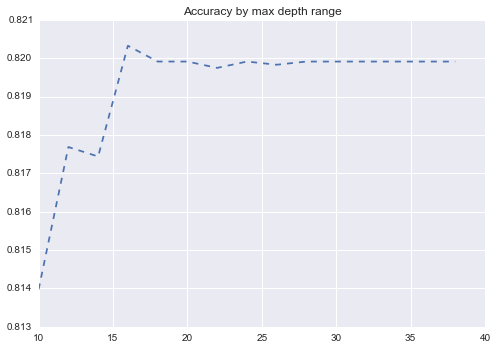

In [57]:
depth_range = range(10,40,2)
scores = []
for depth in depth_range:
    rfc = RandomForestClassifier(n_estimators=50, min_samples_leaf=1, min_samples_split=2, \
                                 class_weight='auto', \
                                 max_features=None, random_state=0, max_depth=depth)
    scores.append(cross_val_score(rfc, df3[features], df3.vacant, cv=10, scoring='accuracy').mean())
plt.plot(depth_range, scores, '--');
# plt.ylim(0,1);
plt.title('Accuracy by max depth range');

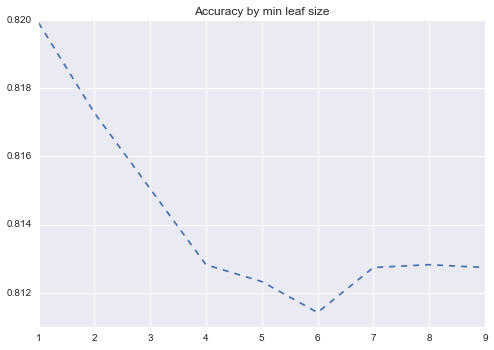

In [58]:
leafs = range(1,10,1)
scores = []
for leaf in leafs:
    rfc = RandomForestClassifier(n_estimators=50, min_samples_leaf=leaf, min_samples_split=2, \
                                 class_weight='auto', \
                                 max_features=None, random_state=0, max_depth=20)
    scores.append(cross_val_score(rfc, df3[features], df3.vacant, cv=10, scoring='accuracy').mean())
plt.plot(leafs, scores, '--');
# plt.ylim(0,1);
plt.title('Accuracy by min leaf size');

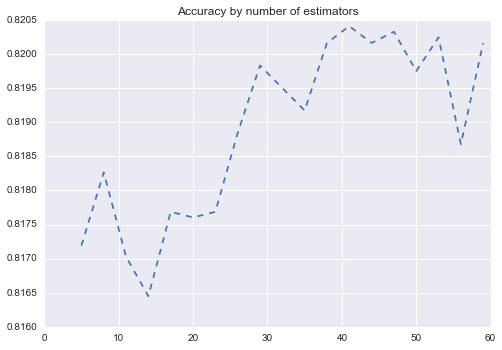

In [59]:
ests = range(5,60,3)
scores = []
for e in ests:
    rfc = RandomForestClassifier(n_estimators=e, min_samples_leaf=1, min_samples_split=2, \
                                 class_weight='auto', \
                                 max_features=None, random_state=0, max_depth=22)
    scores.append(cross_val_score(rfc, df3[features], df3.vacant, cv=10, scoring='accuracy').mean())
plt.plot(ests, scores, '--');
# plt.ylim(0,1);
plt.title('Accuracy by number of estimators');

In [142]:
# param_grid = { 
# #     'n_estimators': [100, 700],
# #     'class_weight': ['auto',None],
#     'min_samples_leaf': [2,4,6],
#     'max_depth': [9,12,16]
# }
# CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)
# CV_rfc.fit(train[features], y)
# print CV_rfc.best_params_

#### Evaluation of model

In [213]:
rfc = RandomForestClassifier(n_estimators=50, min_samples_leaf=2, min_samples_split=2, \
                                 class_weight={0:1, 1:2}, \
                                 max_features=None, random_state=0, max_depth=30)
rfc = rfc.fit(train[features], y)
sound()

In [214]:
pd.crosstab(test.vacant, rfc.predict(test[features]))

col_0,0,1
vacant,,
0,30016,445
1,1829,1164


In [215]:
rfc_prob = rfc.predict_proba(test[features])

0.673237554293


pred,0.0,1.0
vacant,,
0,2539,446
1,851,1164


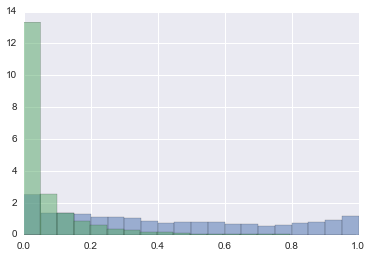

In [216]:
tem = test.copy()
tem['prob'] = rfc_prob[:,1]
tem['pred'] = tem.prob.apply(round)
plt.hist(tem[tem.vacant==1].prob.values,alpha=0.5,normed=True, bins=20);
plt.hist(tem[tem.vacant==0].prob.values,alpha=0.5,normed=True, bins=20);
print sum(tem.sort('prob', ascending=False).iloc[0:5000].vacant)*1.0/sum(tem.vacant)
pd.crosstab(tem.sort('prob', ascending=False).iloc[0:5000].vacant,tem.sort('prob', ascending=False).iloc[0:5000].pred)

In [95]:
pd.crosstab(tem.vacant, (tem.prob+0.3).apply(round))

prob,0.0,1.0
vacant,,
0,23014,1628
1,665,1066


In [46]:
pd.crosstab(test.vacant,test.vindall_Y)

vindall_Y,0.0,1.0
vacant,,
0,25174,1673
1,1479,1092


In [47]:
pd.crosstab(tem.vacant, (tem.prob+0.1).apply(round))

prob,0.0,1.0
vacant,,
0,26266,581
1,1246,1325


In [286]:
sum(tem.vacant), len(tem)

(2578, 29578)

In [322]:
tem.iloc[5000].prob

0.0023567439

In [142]:
round(len(tem)*0.05)

1636.0

In [143]:
tem[(tem.vacant==1)&(tem.pred==0)].shape

(1572, 134)

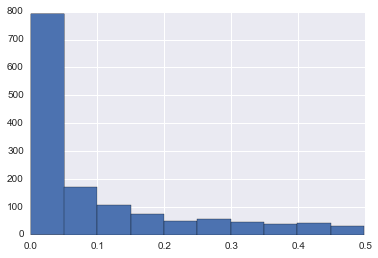

In [323]:
plt.hist(tem[(tem.vacant==1)&(tem.pred==0)].prob.values);

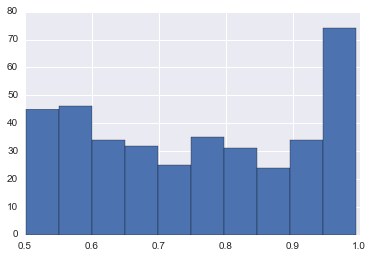

In [324]:
plt.hist(tem[(tem.vacant==0)&(tem.pred==1)].prob.values);

In [325]:
fil = tem.sort('prob',ascending=False)
fil['pred'] = fil['prob'].apply(round)
fil = fil.iloc[0:int(round(len(tem)*0.1))]
pd.crosstab(fil['vacant'], fil['pred'])

pred,0.0,1.0
vacant,,
0,1000,380
1,410,1168


Feature ranking:
1. feature 74, c_O.V.V. (0.239472)
2. feature 87, GRAND_TOTAL_BALANCE (0.133909)
3. feature 26, tmktval (0.062929)
4. feature 62, vindall_Y (0.051582)
5. feature 25, totusabl (0.051414)
6. feature 30, yrbuilt_filtered (0.030463)
7. feature 64, violations_number (0.026351)
8. feature 27, condition_value (0.024652)
9. feature 60, num_of_transfers (0.017927)
10. feature 80, foreclosure_flag (0.015730)
11. feature 65, violations_number_1_yr (0.013812)
12. feature 31, vacant_block (0.013056)
13. feature 32, owner (0.012433)
14. feature 40, bachelors+ (0.012421)
15. feature 47, other (0.011932)
16. feature 33, renter (0.011583)
17. feature 51, old (0.011462)
18. feature 36, burglaries (0.011019)
19. feature 42, median_hh_income (0.010924)
20. feature 34, median_rent (0.010709)


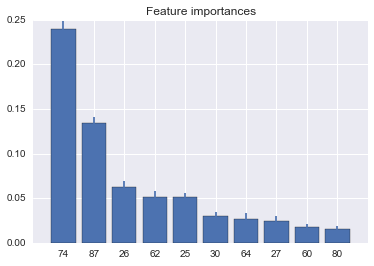

In [96]:
# plot the top ten features

importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(20):
    print("%d. feature %d, %s (%f)" % (f + 1, indices[f], features[indices[f]], importances[indices[f]]))
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(10), importances[indices[0:10]], yerr=std[indices[0:10]], align="center")
plt.xticks(range(10), indices[0:10])
plt.xlim([-1, 10])
plt.show()

In [99]:
sum(df3.auction_13)

0.0

Feature ranking (least important):
1. feature 88, is_train (0.000000)
2. feature 86, auction_all (0.000000)
3. feature 85, auction_13 (0.000000)
4. feature 24, style__Townhouse (0.000125)
5. feature 66, c_Black Mold (0.000143)
6. feature 82, fc_newly_filed (0.000162)
7. feature 6, deed__Sheriffs Deed (0.000197)
8. feature 61, county_land_bank (0.000272)
9. feature 1, deed__Limited Warranty (0.000286)
10. feature 55, limited_warranty (0.000315)
11. feature 22, style__Other (0.000398)
12. feature 70, c_Electrical (0.000515)
13. feature 57, fiduciary_deed (0.000600)
14. feature 69, c_Debris/Garbage/Junk (Occupied) (0.000613)
15. feature 67, c_Collapsing Structure (0.000659)
16. feature 78, complaint_count_3_mon (0.000684)
17. feature 63, vindall_P (0.000714)
18. feature 73, c_No Permit (0.000755)
19. feature 19, style__Bungalow (0.000830)
20. feature 9, deed__Warranty Deed Ex (0.000854)


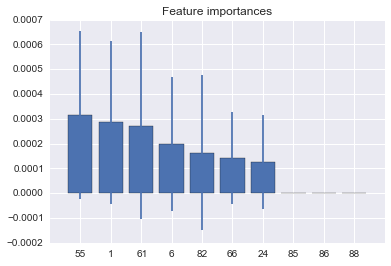

In [97]:
# Print the feature ranking
print("Feature ranking (least important):")

for f in range(20):
    print("%d. feature %d, %s (%f)" % (f + 1, indices[-f-1], features[indices[-f-1]], importances[indices[-f-1]]))
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(10), importances[indices[-10:]], yerr=std[indices[-10:]], align="center")
plt.xticks(range(10), indices[-10:])
plt.xlim([-1, 10])
plt.show()

### Logistic Regressor

In [334]:
train_lr = preprocessing.scale(train[features])
test_lr = preprocessing.scale(test[features])

In [382]:
lr = LogisticRegression(class_weight={0:1, 1:2})
lr.fit(pd.DataFrame(train_lr, columns = features), y)

LogisticRegression(C=1.0, class_weight={0: 1, 1: 2}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0)

In [381]:
pd.crosstab(test['vacant'], lr.predict(pd.DataFrame(test_lr, columns = features)), rownames=['actual'], colnames=['preds'])

preds,0,1
actual,,
0,26689,311
1,1550,1028


In [343]:
pd.crosstab(test['vacant'], lr.predict(pd.DataFrame(test_lr, columns = features)), rownames=['actual'], colnames=['preds'])

preds,0,1
actual,,
0,26689,311
1,1550,1028


In [346]:
abs(lr.coef_)

array([[  1.57375639e-02,   4.37676849e-02,   1.00628089e-02,
          1.13201435e-02,   2.09715741e-02,   1.16242473e-02,
          1.23275749e-01,   2.20340565e-02,   2.08475174e-02,
          8.66040975e-03,   4.68127860e-02,   4.50823906e-02,
          4.45265557e-02,   1.28707941e-02,   3.66715958e-02,
          9.48174585e-03,   5.04114534e-02,   2.87617108e-03,
          3.52261501e-02,   1.52302445e-02,   3.95509299e-03,
          7.94405119e-03,   2.38944448e-02,   1.23326079e-02,
          5.50237643e-02,   2.33603937e-02,   3.24453308e-01,
          3.14600191e-01,   1.45127972e-01,   6.75484639e-05,
          1.20134504e-01,   1.08188638e-01,   6.09684198e-02,
          4.83039116e-02,   2.66717793e-02,   9.87187809e-02,
          6.43297738e-02,   1.08532744e-02,   4.80049365e-02,
          4.76435356e-02,   4.57238319e-02,   7.57005820e-02,
          4.21688320e-02,   8.42267080e-02,   2.13027519e-02,
          4.48471573e-02,   5.60638491e-02,   2.65106657e-02,
        

In [360]:
importances = lr.coef_[0]
# std = np.std([tree.feature_importances_ for tree in lr.estimators_],
#              axis=0)
indices = np.argsort(abs(importances))[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(20):
    print("%d. feature %d, %s (%f)" % (f + 1, indices[f], features[indices[f]], importances[indices[f]]))
print("\nFeature ranking (least important):")
for f in range(20):
    print("%d. feature %d, %s (%f)" % (f + 1, indices[-f-1], features[indices[-f-1]], importances[indices[-f-1]]))

Feature ranking:
1. feature 65, application acceptance count (0.360882)
2. feature 111, GRAND_TOTAL_BALANCE (0.354598)
3. feature 62, vindall_Y (0.341891)
4. feature 26, tmktval (-0.324453)
5. feature 27, condition_value (-0.314600)
6. feature 64, closure count (-0.291210)
7. feature 99, c_O.V.V. (0.249977)
8. feature 104, active_fc (0.175522)
9. feature 48, hispanic (-0.157887)
10. feature 28, ownerocc_value (-0.145128)
11. feature 60, num_of_transfers (-0.129115)
12. feature 6, deed__Sheriffs Deed (0.123276)
13. feature 58, AMOUNT_PAID (0.122505)
14. feature 108, fc_default (0.121150)
15. feature 30, yrbuilt_filtered (-0.120135)
16. feature 79, v_condemnation - main structure_count (0.116467)
17. feature 31, vacant_block (0.108189)
18. feature 106, fc_dis_w/o_prej (0.100024)
19. feature 35, property_crimes (0.098719)
20. feature 78, v_condemnation - garage_count (-0.094970)

Feature ranking (least important):
1. feature 113, is_train (0.000000)
2. feature 110, auction (0.000000)
3. f

### Adaboost Classifier

In [188]:
from sklearn.ensemble import AdaBoostClassifier

In [189]:
abc = AdaBoostClassifier(n_estimators=50, random_state=0)
abc.fit(train[features], y)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=0)

In [190]:
cross_val_score(abc, df3[features], df3.vacant, cv=10, scoring='accuracy').mean()

0.85570079795738163

In [192]:
sound()

In [74]:
abc_prob = abc.predict_proba(test[features])

In [193]:
pd.crosstab(test['vacant'], abc.predict(test[features]), rownames=['actual'], colnames=['preds'])

preds,0,1
actual,,
0,32801,556
1,2078,1614


### Single decision tree

In [194]:
from sklearn import tree

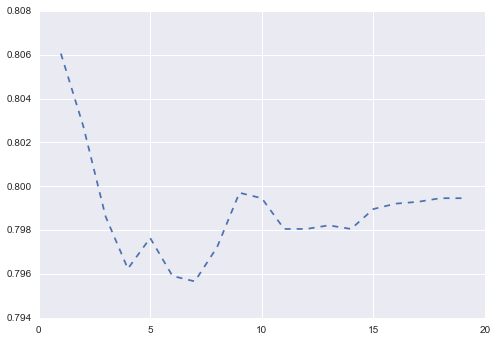

In [77]:
leafs = range(1,20,1)
scores = []
for leaf in leafs:
    clf = tree.DecisionTreeClassifier(class_weight='auto', min_samples_leaf=leaf)
    scores.append(cross_val_score(clf, df3[features], df3.vacant, cv=10, scoring='accuracy').mean())
plt.plot(leafs, scores, '--');

In [195]:
clf = tree.DecisionTreeClassifier(class_weight='auto', min_samples_leaf=2)
clf = clf.fit(train[features], y)

In [196]:
cross_val_score(clf, df3[features], df3.vacant, cv=10, scoring='accuracy').mean()

0.76765186629132975

In [197]:
pd.crosstab(test['vacant'], clf.predict(test[features]), rownames=['actual'], colnames=['preds'])

preds,0,1
actual,,
0,31251,2106
1,1478,2214


## xgboost

In [227]:
train.as_matrix()

array([[0.0, 0.0, 1.0, ..., 2503.22, 1, True],
       [0.0, 0.0, 0.0, ..., 2367.62, 1, True],
       [0.0, 0.0, 0.0, ..., 2486.62, 1, True],
       ..., 
       [0.0, 0.0, 0.0, ..., 3185.46, 1, True],
       [1.0, 0.0, 0.0, ..., 2158.96, 1, True],
       [0.0, 0.0, 0.0, ..., 2825.78, 1, True]], dtype=object)

In [312]:
xgtest = test[features].as_matrix()
#create train and validation dmatrices 
xgtrain = train[features].as_matrix()

In [363]:
gbm = xgb.XGBClassifier(max_depth=50, n_estimators=100, learning_rate=0.1).fit(xgtrain, y)
predictions = gbm.predict(xgtest)
probs = gbm.predict_proba(xgtest)

In [364]:
pd.crosstab(test['vacant'],predictions)

col_0,0,1
vacant,,
0,26627,373
1,1415,1163


In [365]:
sound()

0.723041117145


pred,0.0,1.0
vacant,,
0,2763,373
1,701,1163


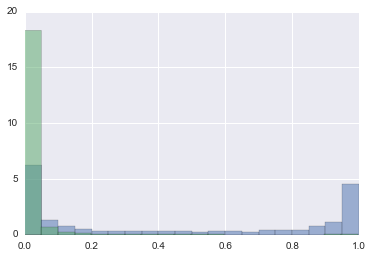

In [366]:
tem = test.copy()
tem['prob'] = probs[:,1]
tem['pred'] = tem.prob.apply(round)
plt.hist(tem[tem.vacant==1].prob.values,alpha=0.5,normed=True, bins=20);
plt.hist(tem[tem.vacant==0].prob.values,alpha=0.5,normed=True, bins=20);
print sum(tem.sort('prob', ascending=False).iloc[0:5000].vacant)*1.0/sum(tem.vacant)
pd.crosstab(tem.sort('prob', ascending=False).iloc[0:5000].vacant,tem.sort('prob', ascending=False).iloc[0:5000].pred)

In [262]:
pd.crosstab(tem.sort('prob', ascending=False).iloc[0:5000].vacant,tem.sort('prob', ascending=False).iloc[0:5000].pred)

pred,0.0,1.0
vacant,,
0,1748,303
1,342,2607


In [253]:
pd.crosstab(tem.sort('prob', ascending=False).iloc[0:5000].vacant,tem.sort('prob', ascending=False).iloc[0:5000].pred)

pred,0.0,1.0
vacant,,
0,2247,479
1,751,1523
